In [46]:
import os
import sys

sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
import igraph as ig
import gseapy

In [13]:
from GmGM import GmGM
from utilities import shrink_per_col
from other_algs.EiGLasso import EiGLasso

In [29]:
import time

# Load Data

In [3]:
# Get data from:
# https://www.10xgenomics.com/resources/datasets/fresh-frozen-lymph-node-with-b-cell-lymphoma-14-k-sorted-nuclei-1-standard-2-0-0

# Load data
mudata = mu.read_10x_h5(
    os.path.join(
        "../data/10x-Genomics/",
        "lymph_node_lymphoma_14k_filtered_feature_bc_matrix.h5"
    )
)

mudata

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from ../data/10x-Genomics/lymph_node_lymphoma_14k_filtered_feature_bc_matrix.h5


/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


MuData object with n_obs × n_vars = 14566 × 146390
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	14566 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	14566 x 109789
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [4]:
rna = mudata["rna"]
rna.var_names_make_unique()

atac = mudata["atac"]
atac.var_names_make_unique()
mudata.update()


# Preprocess Data

In [5]:
# Add mitochondrial info
rna.var['mt'] = rna.var_names.str.startswith('MT-')

sc.pp.calculate_qc_metrics(
    rna,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

rna.obs["log_genes_by_counts"] = np.log10(
    rna.obs["n_genes_by_counts"] + 1
)

# Calculate median absolute deviation of n_genes_by_counts
med = np.median(rna.obs['log_genes_by_counts'])
mad = np.median(
    np.abs(
        rna.obs['log_genes_by_counts'] - med
    )
)

# Filter out cells with any mitochondrial genes
# Because this is a single-nucleus experiment, and we expect
# the mitochondria to be in the cytoplasm (not the nucleus),
# any presence is likely to be a technical artifact.
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x == 0)

# Filter out cells with too many or too few genes
# (Based on 3 median absolute deviations from the median)
mu.pp.filter_obs(
    rna,
    'log_genes_by_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

#===#
# Filter out low quality genes
#===#

rna.var["log_cells_by_counts"] = np.log10(
    rna.var["n_cells_by_counts"]+1
)
med = np.median(rna.var["log_cells_by_counts"])
mad = np.median(
    np.abs(
        rna.var["log_cells_by_counts"] - med
    )
)

# Filter out genes with less than 3 cells
mu.pp.filter_var(
    rna,
    'n_cells_by_counts',
    lambda x: x >= 3
)

# Filter out genes outside of 3 median absolute deviations
# Note that this won't do anything, all are within 3 MADs
mu.pp.filter_var(
    rna,
    'log_cells_by_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

#===#
# Normalize genes
#===#

sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

# Find and label highly variable genes
sc.pp.highly_variable_genes(
    rna,
    min_mean=0.02,
    max_mean=4,
    min_disp=0.5
)

#===#
# Filter out low quality peaks
#===#

# Note, because we're using `scanpy`, our peaks
# will be referred to as "genes" here.
sc.pp.calculate_qc_metrics(
    atac,
    percent_top=None,
    log1p=False,
    inplace=True
)

atac.obs['log_total_counts'] = np.log10(
    atac.obs['total_counts']+1
)
atac.obs['log_genes_by_counts'] = np.log10(
    atac.obs['n_genes_by_counts']+1
)
atac.var['log_cells_by_counts'] = np.log10(
    atac.var['n_cells_by_counts']+1
)

# Filter out total_counts within 3 MADs of the median
med = np.median(atac.obs['log_total_counts'])
mad = np.median(np.abs(atac.obs['log_total_counts'] - med))
mu.pp.filter_obs(
    atac,
    'log_total_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

# Filter out n_genes_by_counts within 3 MADs of the median
med = np.median(atac.obs['log_genes_by_counts'])
mad = np.median(np.abs(atac.obs['log_genes_by_counts'] - med))
mu.pp.filter_obs(
    atac,
    'log_genes_by_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

# Filter out n_cells_by_counts within 3 MADs of the median
med = np.median(atac.var['log_cells_by_counts'])
mad = np.median(np.abs(atac.var['log_cells_by_counts'] - med))
mu.pp.filter_var(
    atac,
    'log_cells_by_counts',
    lambda x: (x >= med - 3*mad) & (x < med + 3*mad)
)

#===#
# Normalize peaks
#===#

mu.atac.pp.tfidf(atac, scale_factor=1e4)
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

# Find and label highly variable peaks ("genes")
sc.pp.highly_variable_genes(
    atac,
    min_mean=0.05,
    max_mean=1.5,
    min_disp=1
)

mudata.update()

In [6]:
mudata

MuData object with n_obs × n_vars = 13744 × 125884
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    rna:	2552 x 27489
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log_genes_by_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    atac:	13551 x 98395
      obs:	'n_genes_by_counts', 'total_counts', 'log_total_counts', 'log_genes_by_counts', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

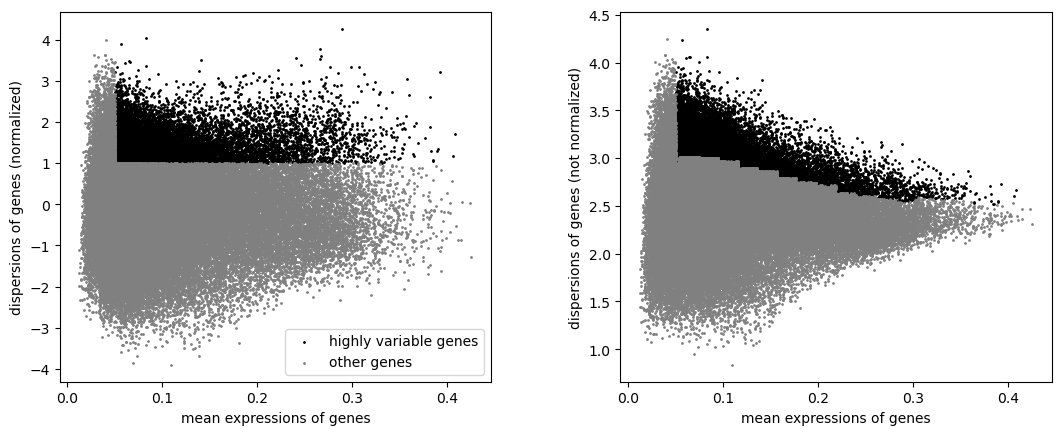

In [7]:
sc.pl.highly_variable_genes(atac)

In [8]:
cells_that_passed_both_tests = np.intersect1d(
    rna.obs_names,
    atac.obs_names
)

# We have to copy b/c can't call `filter_var` on a view :(
filtered_mudata = mudata[cells_that_passed_both_tests].copy()
filtered_mudata.var['highly_variable'] = \
    filtered_mudata.var['highly_variable'].values.to_numpy().astype(bool)

# # Grab just the highly variable genes and peaks
mu.pp.filter_var(
    filtered_mudata,
    'highly_variable',
    lambda x: x
)

In [9]:
filtered_mudata

MuData object with n_obs × n_vars = 2359 × 17835
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    rna:	2359 x 5350
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log_genes_by_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    atac:	2359 x 12485
      obs:	'n_genes_by_counts', 'total_counts', 'log_total_counts', 'log_genes_by_counts', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log_cells_by_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

In [10]:
cell_by_gene = filtered_mudata["rna"].X
cell_by_atac = filtered_mudata["atac"].X

# Experiment 1: GmGM

In [37]:
start_time = time.time()
output = GmGM(
    {
        "RNA": cell_by_gene.toarray(),
        "ATAC": cell_by_atac.toarray()
    },
    {
        "RNA": ("cell", "gene"),
        "ATAC": ("cell", "peak")
    },
)
end_time = time.time()
print(f"GmGM took {end_time - start_time} seconds")

GmGM took 590.14985704422 seconds


In [38]:
shrink_per_col(
    output,
    {
        "cell": 5,
        "gene": 5,
        "peak": 5
    },
    safe=False
)
pass

In [39]:
# Create cell graph
cell_graph = ig.Graph.Adjacency((output["cell"] + output["cell"].T) != 0).as_undirected()

# Do louvain clustering on cell graph
cell_graph.vs["louvain"] = [
    f"Cluster {cluster}"
    for cluster in cell_graph.community_multilevel().membership
]
filtered_mudata.obs["louvain"] = cell_graph.vs["louvain"]

In [48]:
filtered_mudata["rna"].obs["louvain"] = cell_graph.vs["louvain"]

In [40]:
# First run PCA to ease computational load
sc.pp.pca(filtered_mudata['rna'], n_comps=30)
sc.pp.pca(filtered_mudata['atac'], n_comps=30)

# Find nearest neighbors (umap prep)
sc.pp.neighbors(filtered_mudata['rna'])
sc.pp.neighbors(filtered_mudata['atac'])

# Joint neighbor network construction
mu.pp.neighbors(filtered_mudata)

# Now, finally, UMAP
mu.tl.umap(filtered_mudata)

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


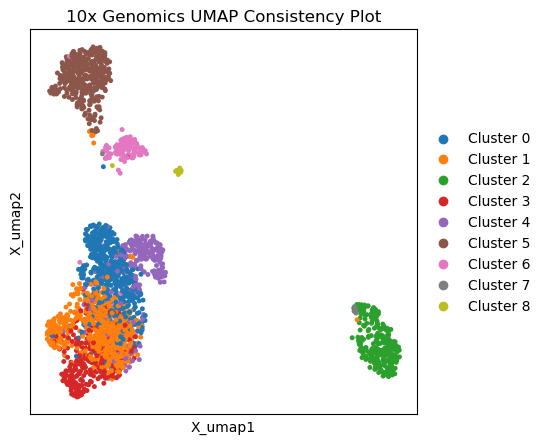

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))
mu.pl.umap(
    filtered_mudata,
    color=["louvain"],
    ax=ax,
    title="10x Genomics UMAP Consistency Plot"
)

In [42]:
fig.savefig("../out_figs/10x-umap.png")
fig.savefig("../out_figs/10x-umap.svg")

## Experiment 1b: Runtime: Unimodal GmGM

In [43]:
start_time = time.time()
GmGM(
    {
        "RNA": cell_by_gene.toarray(),
    },
    {
        "RNA": ("cell", "gene"),
    },
)
end_time = time.time()
print(f"Unimodal GmGM took {end_time - start_time} seconds")

Unimodal GmGM took 51.71026301383972 seconds


In [44]:
start_time = time.time()
GmGM(
    {
        "ATAC": cell_by_atac.toarray(),
    },
    {
        "ATAC": ("cell", "peak"),
    },
)
end_time = time.time()
print(f"Unimodal GmGM [ATAC] took {end_time - start_time} seconds")

Unimodal GmGM [ATAC] took 607.1169550418854 seconds


# Experiment 2: Go Term Analysis

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


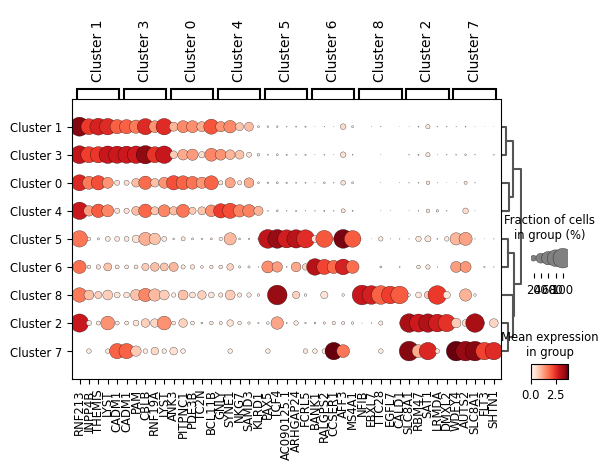

Calculating GO term enrichment for louvain clusters...


In [64]:
# Get the gene sets for humans
gene_set_names = gseapy.get_library_name(organism='Human')

# Louvain DE genes
sc.tl.rank_genes_groups(
    filtered_mudata['rna'],
    'louvain',
    method='wilcoxon',
    key_added='louvain_de'
)

# Dotplot
sc.tl.dendrogram(filtered_mudata['rna'], groupby='louvain')
fig, ax = plt.subplots()
sc.pl.rank_genes_groups_dotplot(
    filtered_mudata['rna'],
    n_genes=5,
    key="louvain_de",
    groupby="louvain",
    ax=ax,
    show=True
)
fig.savefig("../out_figs/louvain_de_dotplot.svg")
plt.close(fig)

print("Calculating GO term enrichment for louvain clusters...")

# louvain
glist_louvain = [None] * 9
for i in range(9):
    glist_louvain[i] = sc.get.rank_genes_groups_df(
        filtered_mudata['rna'],
        key='louvain_de',
        group=f'Cluster {i}',
        pval_cutoff=0.05
    )
    #print(glist_louvain[i]['names'].head())
    #glist_louvain[i]['names'].squeeze().str.strip()

# louvain enrichment
enr_res_louvain = [None] * 9
for i in range(9):
    enr_res_louvain[i] = gseapy.enrichr(
        gene_list=glist_louvain[i][['names', 'logfoldchanges']],
        organism='Human',
        gene_sets=[
            'GO_Biological_Process_2018',
            'GO_Cellular_Component_2018',
            'GO_Molecular_Function_2018',
            'KEGG_2019_Human',
            'Reactome_2016',
            'WikiPathways_2019_Human',
            'NCI-Nature_2016',
            'Panther_2016',
        ]
    )

for i in range(9):
    try:
        gseapy.barplot(
            enr_res_louvain[i].res2d,
            title=f'GO Terms Cluster {i}',
            ofname=f"../out_figs/GO_Terms_Cluster_{i}.svg"
        )
        gseapy.barplot(
            enr_res_louvain[i].res2d,
            title=f'GO Terms Cluster {i}',
            ofname=f"../out_figs/GO_Terms_Cluster_{i}.png"
        )
    except:
        print(f'None in cluster {i}')

# Experiment 3: EiGLasso Runtime
This ran for more than 1000 minutes, so we cancelled it.

In [ ]:
start_time = time.time()
EiGLasso(
    cell_by_gene.toarray()[np.newaxis, ...].astype(np.float64),
    beta_1=0,
    beta_2=0,
)
end_time = time.time()
print(f"EiGLasso took {end_time - start_time} seconds")